# 002 Pairs Trading

## Description

Create a pairs trading strategy using the co-integrated time series approach, implementing a Kalman filter to dynamically calculate the hedge ratio.

## Acceptance criteria:

- Teams of 2
- The GitHub repository contains commits from each member of the team.
- Report has a valid structure with detailed steps & conclusions.
- Code runs, is clean and follows a python's project structure.
- Download 10 years of historical data.
- The linear combination of the stocks are stationary and co-integrated.
- There is an economic relationship between the assets.
- Hedge Ratio is estimated with a Kalman filter.
- Trade using ± 1.5 std.
- The Kalman Filter must be implemented from scratch, no libraries!
- Generate the trading signals using the VECM from the co-integration tests.
- Backtest the strategy, considering margin accounts, commissions of 0.125% and a capital of $1,000,000 USD.

# Pairs Trading

Pairs trading is a market-neutral trading strategy that involves taking long and short positions in two assets that have a high historical correlation. The main idea is to profit from the convergence or divergence of the prices of these assets.

How Does Pairs Trading Work?

1. Pair Selection:
- Two assets that have historically shown a high positive correlation are chosen. This means their prices tend to move together.
    - Common examples include stocks from the same industry, similar ETFs, or even currency pairs.
      
2. Opportunity Identification:
- The price relationship between the two assets is monitored. When this relationship deviates significantly from its historical average, a trading signal is generated.
    - For example, if the price of one asset rises while the other falls, it can be expected that they will eventually converge again.
      
3. Strategy Execution:
- Long Position: The undervalued asset (the one that has decreased in price) is bought.
- Short Position: The overvalued asset (the one that has increased in price) is sold short.
    - The idea is that when the prices return to their historical relationship, a profit will be made from both positions.
      
4. Position Closure:
- Positions are closed when the prices of the assets return to their historical relationship or when a predetermined stop-loss level is reached.

# Cointegration Tests

## Cointegrated Pairs

Cointegrated pairs are two or more assets whose prices, although individually non-stationary (because they follow trends or have changing volatility), maintain a stable long-term relationship. This relationship implies that the distance between them follows a stationary behavior, making them ideal candidates for strategies such as pairs trading.

###### How to Detect Cointegration

- **Engle-Granger Test**: Evaluates whether the residuals of a regression between the assets are stationary.
- **Johansen Test**: Evaluates multiple cointegration vectors in multivariate series.

###### Applications in Finance

- **Pairs Trading**: Buying the undervalued asset and selling the overvalued one when they deviate from their historical relationship, expecting them to converge again.


In [4]:
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pandas as pd
import numpy as np
import ta

[*********************100%***********************]  7 of 7 completed


Unit Root Tests: (Augmented) Dickey-Fuller
GOOGL: ADF Statistic = 0.6734510797555243, p-value = 0.9892928722508465
IBM: ADF Statistic = 0.14354645359047263, p-value = 0.9689114926646946
AXP: ADF Statistic = 1.5035885663305608, p-value = 0.9975374683752121
AAPL: ADF Statistic = 0.797342817866423, p-value = 0.9915931548305212
VOO: ADF Statistic = 0.7231468962478572, p-value = 0.9902886641892265
WMT: ADF Statistic = 2.5218944132571703, p-value = 0.9990565721853198
COST: ADF Statistic = 1.8869566970811313, p-value = 0.9985067430682019

Engle-Granger Two-Step Method: P1 linear relation
Cointegration test for ('GOOGL', 'IBM'): score = -2.6168093847224774, p-value = 0.2301126456795936
Cointegration test for ('GOOGL', 'AXP'): score = -3.477383626805986, p-value = 0.034453637688823834
Cointegration test for ('GOOGL', 'AAPL'): score = -3.2654724297956594, p-value = 0.059643875846604404
Cointegration test for ('GOOGL', 'VOO'): score = -4.468055633463272, p-value = 0.0013813536145788378
Cointegrat

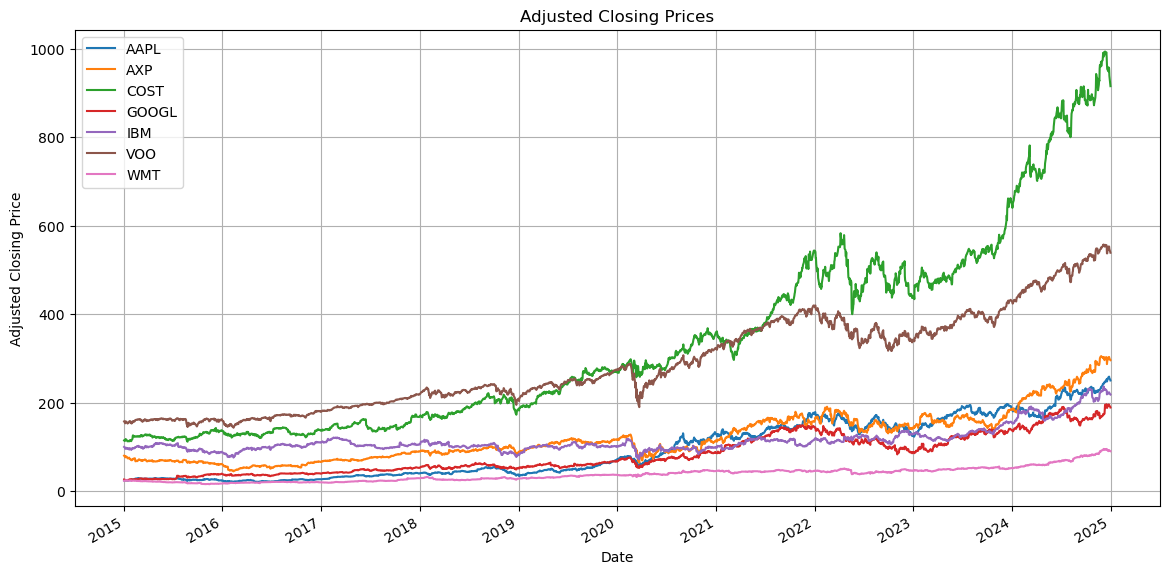

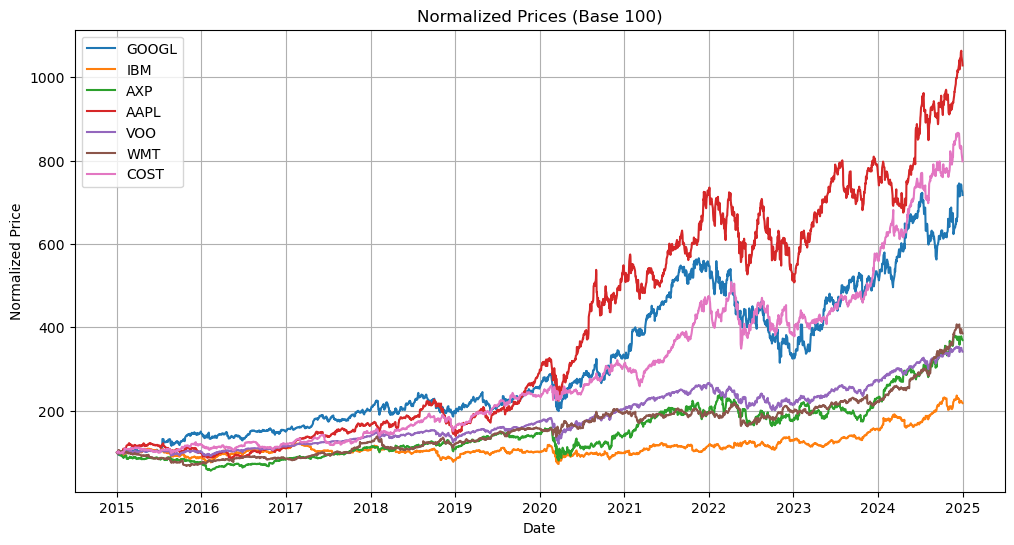

In [5]:
# Function download prices from YahooFinance
def get_adj_closes(tickers, start_date=None, end_date=None, freq='1d'):
    data = yf.download(tickers, start=start_date, end=end_date, interval=freq, auto_adjust=True)
    data.sort_index(inplace=True)
    return data['Close']

# Download prices
tickers_test = [ 'GOOGL','IBM','AXP','AAPL','VOO','WMT','COST']
closes_test = get_adj_closes(tickers_test, start_date='2015-01-01', end_date='2025-01-01')

# Function for uniroot test (Dickey-Fuller)
def adf_test(series):
    result = adfuller(series)
    return result[0], result[1]  # ADF Statistic, p-value

# Function for cointegration test (Engle-Granger)
def check_cointegration(series1, series2):
    score, p_value, _ = coint(series1, series2)
    return score, p_value

# Verificar raíz unitaria y cointegración entre pares de activos
results_adf = {}
results_coint = {}
for i in range(len(tickers_test)):
    adf_stat, adf_p_value = adf_test(closes_test[tickers_test[i]])
    results_adf[tickers_test[i]] = (adf_stat, adf_p_value)
    
    for j in range(i + 1, len(tickers_test)):
        coint_score, coint_p_value = check_cointegration(closes_test[tickers_test[i]], closes_test[tickers_test[j]])
        results_coint[(tickers_test[i], tickers_test[j])] = (coint_score, coint_p_value)

# Show uniroot results (Dickey-Fuller)
print("Unit Root Tests: (Augmented) Dickey-Fuller")
for ticker_test, (adf_stat, adf_p_value) in results_adf.items():
    print(f'{ticker_test}: ADF Statistic = {adf_stat}, p-value = {adf_p_value}')

# Show cointegration results (Engle-Granger)
print("\nEngle-Granger Two-Step Method: P1 linear relation")
for pair, (coint_score, coint_p_value) in results_coint.items():
    print(f'Cointegration test for {pair}: score = {coint_score}, p-value = {coint_p_value}')

# Plot the assets
closes_test.plot(figsize=(14, 7))
plt.title('Adjusted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.legend(closes_test.columns)
plt.grid(True)
plt.show()

normalized_closes = closes_test / closes_test.iloc[0] * 100  

plt.figure(figsize=(12, 6))
for ticker_test in tickers_test:
    plt.plot(normalized_closes.index, normalized_closes[ticker_test], label=ticker_test)

plt.title("Normalized Prices (Base 100)")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(True)
plt.show()


## American Express & Google

#### Reasons for Asset Selection:

- **Economic Relationship**: American Express and Google have a significant economic relationship through their collaboration on Google Pay. American Express cardholders can use Google Pay to make purchases at establishments that accept contactless payments

- **Growth and Stability**: Both companies have shown consistent growth and a dominant position in their respective markets. American Express is a leader in financial services, while Google is a giant in technology and digital services

- **Market Synergies**: The relationship between American Express and Google suggests that their returns may be cointegrated due to macroeconomic factors that affect both companies similarly. The integration of American Express cards with Google Pay and the provision of specialized financial services for businesses are examples of these synergies

American Express and Google passed the initial Augmented Dickey-Fuller (ADF) test, indicating that both assets exhibit a unit root.

We can proceed with the other tests.


# OLS

Ordinary Least Squares (OLS) is a fundamental method in linear regression. It is used to find the coefficients of a line that minimize the sum of the squared errors between the predicted values and the actual values.

Given a linear model like:

$$Y = \beta_0 + \beta_1 X + \epsilon$$

- **Y**: Dependent variable (e.g., option price).
- **X**: Independent variable (e.g., price of the underlying asset).
- **$\beta_0$ and $\beta_1$**: Coefficients to be estimated.
- **$\epsilon$**: Error term (noise).

OLS estimates the coefficients $\beta_0$ and $\beta_1$ by minimizing:

$$\min \sum (Y_i - \hat{Y_i})^2$$

Where $\hat{Y_i}$ is the value predicted by the model.

In [8]:
# Download prices
tickers = ['AXP','GOOGL']
closes = get_adj_closes(tickers, start_date='2015-01-01', end_date='2025-01-01')

# Drop missing values
closes.dropna(inplace=True)

# Define dependent and independent variables
Y = closes['AXP']
X = closes['GOOGL']

# Test if the spread is stationary
spread = Y - (X * 1.2073 + 21.2193)
adf_result = adfuller(spread)
adf_stat, p_value = adf_result[0], adf_result[1]

print(f"ADF Test Statistic: {adf_stat}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("The spread is stationary (cointegration detected).")
else:
    print("The spread is NOT stationary (no cointegration).")

# Run OLS regression
X = sm.add_constant(X)  # Add constant term
model = sm.OLS(Y, X).fit()

# Print regression summary
print(model.summary())

[*********************100%***********************]  2 of 2 completed

ADF Test Statistic: -3.13712620251304
P-value: 0.02392491944506793
The spread is stationary (cointegration detected).
                            OLS Regression Results                            
Dep. Variable:                    AXP   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 2.107e+04
Date:                Tue, 11 Mar 2025   Prob (F-statistic):               0.00
Time:                        17:40:35   Log-Likelihood:                -10865.
No. Observations:                2516   AIC:                         2.173e+04
Df Residuals:                    2514   BIC:                         2.175e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

## Results of the Second Tests

- **R-squared**: > 0.70 = 0.908
- **Omnibus**: < 0.05 = 0.000
- **JB**: < 0.05 = 0.000

These results demonstrate that the spread of the assets is stationary, confirming cointegration.

# Johansen Test

The Johansen test is a statistical method used to determine whether multiple time series are cointegrated, meaning there is a long-term equilibrium relationship between them. Unlike the Engle-Granger test, which can only identify one cointegration relationship, the Johansen test allows for the detection of multiple cointegration relationships simultaneously.

On the other hand, the VECM (Vector Error Correction Model) signal is a tool used in econometrics to model the long-term relationship between cointegrated variables and how these variables adjust in the short term to correct any deviations from the long-term equilibrium.

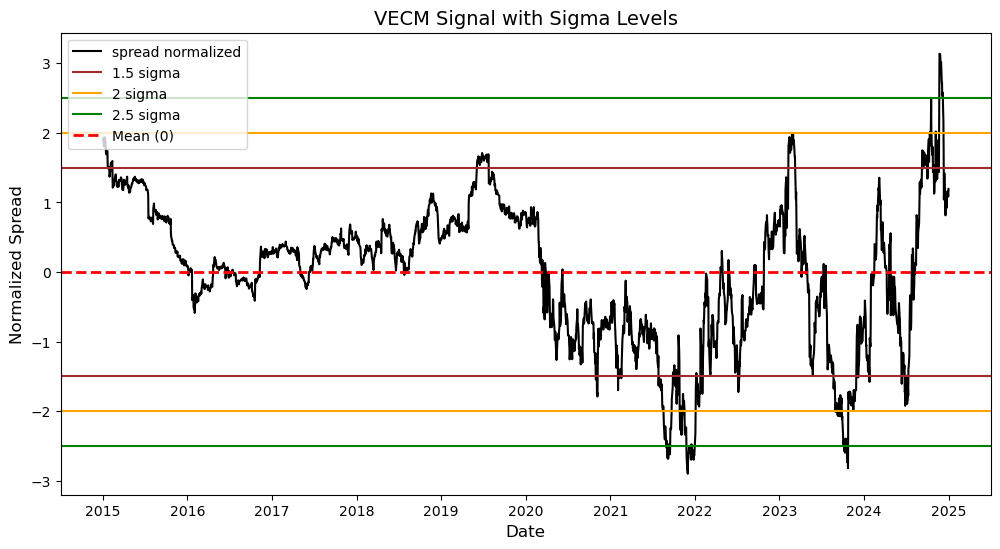

In [11]:
data = closes[['AXP','GOOGL']].values
# Run Johansen cointegration test
johansen_test = coint_johansen(data, det_order=0, k_ar_diff=1)

# Extract cointegration vector (eigenvector)
cointegration_vector = johansen_test.evec[:, 0]

# Compute the raw spread
spread = data @ cointegration_vector  # Matrix multiplication of prices with eigenvector

# Normalize the spread to have mean 0 and std 1
spread_mean = np.mean(spread)
spread_std = np.std(spread)
spread_normalized = (spread - spread_mean) / spread_std

# Construct the normalized spread model equation
spread_model = f"u_t = {cointegration_vector[0]:.5f} * x_t - {cointegration_vector[1]:.5f} * y_t"

# Plot the normalized spread with sigma levels
plt.figure(figsize=(12, 6))
plt.plot(closes.index, spread_normalized, label="spread normalized", color="black")

# Sigma levels and their colors
sigma_levels = {1.5: "brown", 2: "orange", 2.5: "green"}
for sigma, color in sigma_levels.items():
    plt.axhline(sigma, color=color, linestyle='-', linewidth=1.5, label=f"{sigma} sigma")
    plt.axhline(-sigma, color=color, linestyle='-', linewidth=1.5)

# Mean line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label="Mean (0)")

# Formatting
plt.title("VECM Signal with Sigma Levels", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Spread", fontsize=12)
plt.legend(loc="upper left")
plt.show()

# Kalman Filter and Backtesting

The Kalman filter is a mathematical technique used to estimate unobservable variables from noisy observations. In the context of trading, it can be used to calculate a dynamic hedge ratio between two assets that have a cointegration relationship. This allows for real-time adjustment of the hedge ratio, improving the accuracy and profitability of hedging strategies.

#### Kalman Filter with Hedge Ratio

To calculate a dynamic hedge ratio, the Kalman filter treats the hedge ratio as an unobservable state variable and uses the asset prices as noisy observations. The process involves two main steps in each iteration:

1. **Prediction**:

- Predicts the current state (hedge ratio) based on the previous state.
- Updates the prediction error covariance.
  
2. **Update**:

- Calculates the Kalman gain, which determines how much the prediction should be adjusted based on the new observation.
- Updates the state (hedge ratio) and the prediction error covariance.

#### Backtesting

Backtesting is the process of evaluating a trading strategy using historical data to determine how it would have performed in the past. This process is crucial for validating the effectiveness of a strategy before implementing it in the real market. Here are the key steps to perform backtesting:

### Steps to Perform Backtesting

1. **Define the Trading Strategy**:

- Establish the rules for entering and exiting positions.
- Determine the technical indicators and parameters to be used.

2. **Obtain Historical Data**:

- Download historical data for the financial assets to be analyzed.
- Ensure the data is clean and organized.
  
3. **Apply the Strategy to Historical Data**:

- Simulate buy and sell operations according to the defined rules.
- Calculate the performance of each operation and the portfolio value over time.
  
4. **Evaluate the Strategy's Performance**:

- Analyze key metrics such as total return, rate of return, maximum drawdown, Sharpe ratio, etc.
- Compare the strategy's performance with a benchmark or reference index.

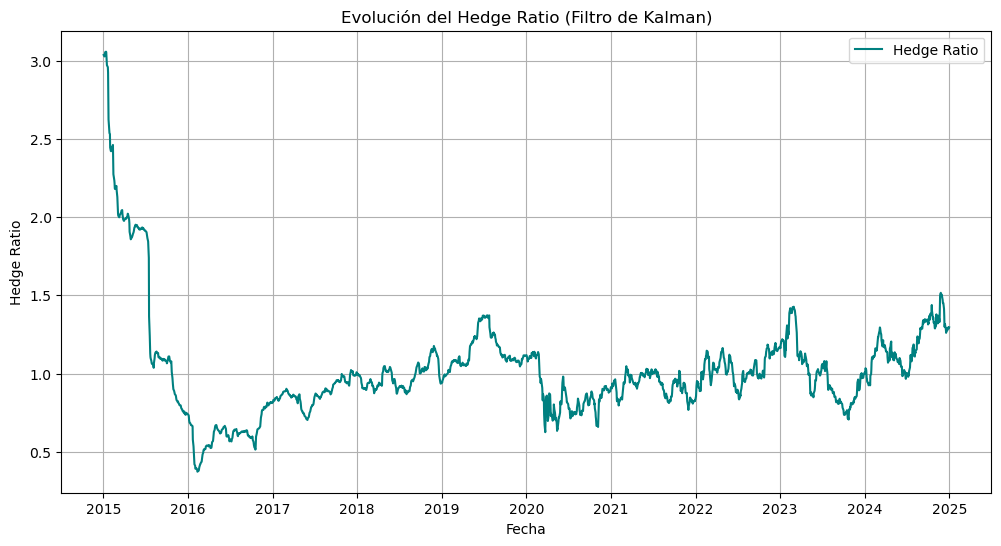

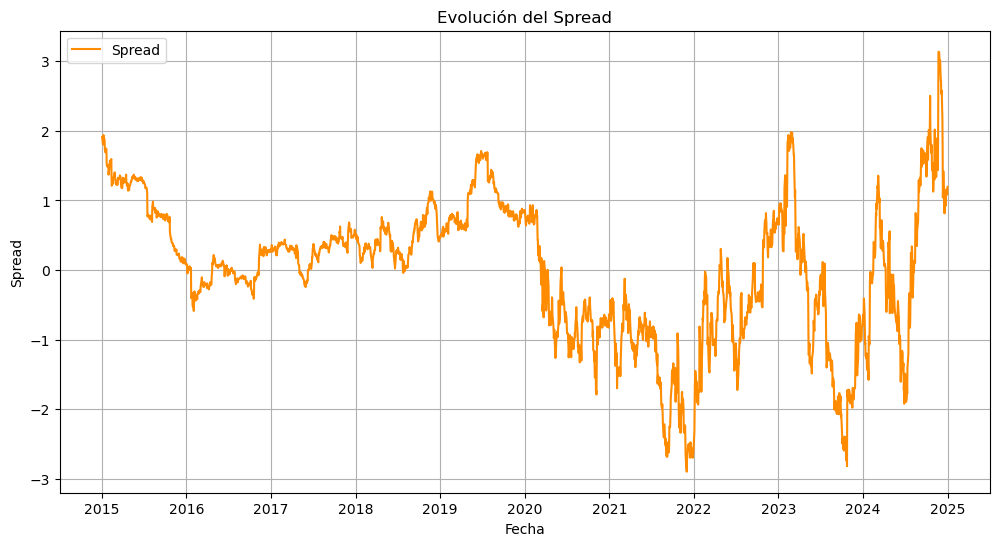

In [13]:
# 2. Implementar filtro de Kalman para calcular hedge ratio
class KalmanFilterHedgeRatio:
    def __init__(self):
        self.x = np.array([0, 0])
        self.A = np.eye(2)
        self.Q = np.eye(2) * 0.01
        self.R = np.array([[1]]) * 100
        self.P = np.eye(2) * 1000

    def predict(self):
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, x, y):
        C = np.array([[1, x]])
        S = C @ self.P @ C.T + self.R
        K = self.P @ C.T @ np.linalg.inv(S)
        self.P = (np.eye(2) - K @ C) @ self.P
        self.x = self.x + K @ (y - C @ self.x)

kalman_filter = KalmanFilterHedgeRatio()
hedge_ratios = []
spread_values = []

for i in range(len(closes)):
    kalman_filter.predict()
    x_ = closes['GOOGL'].iloc[i]
    y_ = closes['AXP'].iloc[i]
    kalman_filter.update(x_, y_)
    
    w1 = kalman_filter.x[1]
    w1 = np.clip(w1, -10, 10)
    hedge_ratios.append(w1)
    spread = y_ - w1 * x_
    spread_values.append(spread)

closes['HedgeRatio'] = hedge_ratios
closes['Spread'] = spread_normalized


# Gráfica de Hedge Ratio
plt.figure(figsize=(12, 6))
plt.plot(closes.index, closes['HedgeRatio'], label='Hedge Ratio', color='teal')
plt.title('Evolución del Hedge Ratio (Filtro de Kalman)')
plt.xlabel('Fecha')
plt.ylabel('Hedge Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de Spread
plt.figure(figsize=(12, 6))
plt.plot(closes.index, closes['Spread'], label='Spread', color='darkorange')
plt.title('Evolución del Spread')
plt.xlabel('Fecha')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
closes.head()

Ticker,AXP,GOOGL,HedgeRatio,Spread
Date,,,,
2015-01-02,80.133896,26.351517,3.036150,1.909826
2015-01-05,78.014656,25.849413,3.026815,1.840553
2015-01-06,76.352020,25.211466,3.026711,1.803213
2015-01-07,78.019577,25.137320,3.035918,1.890423
2015-01-08,79.125511,25.224903,3.049876,1.938731


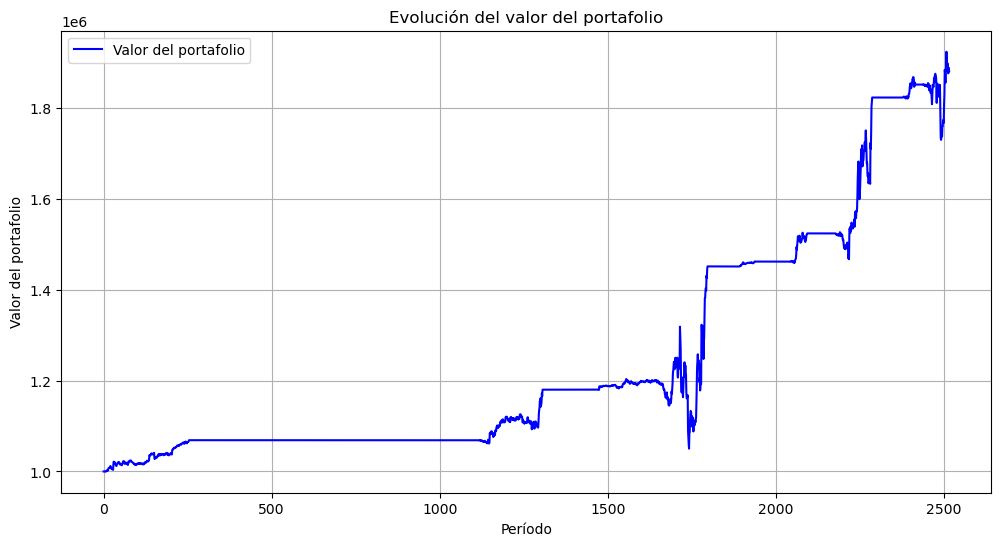

Valor final del portafolio: $1,881,495.38


In [16]:
shares = 100
com = 0.125 / 100

active_positions = []
active_short_positions = []

capital = 1_000_000
portfolio_value = [capital]

for i, row in closes.iterrows():
    spread = row['Spread']

    # Compra AXP y vende corto COST si spread > 1.5
    if spread < -1.5:
        if capital >= (row['AXP'] * shares * (1 + com)):
            capital -= row['AXP'] * shares * (1 + com)
            active_positions.append({
                "date": row.name,
                "ticker": 'AXP',
                "bought_at": row['AXP'],
                "shares": shares
            })
        if capital >= (row['GOOGL'] * shares * (1 + com)):
            capital -= row['GOOGL'] * shares * (com)
            active_short_positions.append({
                "date": row.name,
                "ticker": 'GOOGL',
                "bought_at": row['GOOGL'],
                "shares": shares
            })
    
    # Compra COST y vende corto AXP si spread < -1.5
    elif spread > 1.5:
        if capital >= (row['GOOGL'] * shares * (1 + com)):
            capital -= row['GOOGL'] * shares * (1 + com)
            active_positions.append({
                "date": row.name,
                "ticker": 'GOOGL',
                "bought_at": row['GOOGL'],
                "shares": shares
            })
        if capital >= (row['AXP'] * shares * com):
            capital -= row['AXP'] * shares * (com)
            active_short_positions.append({
                "date": row.name,
                "ticker": 'AXP',
                "bought_at": row['AXP'],
                "shares": shares
            })

    # Cierre de posiciones si spread es 0
    if abs(spread) <= 0.05:
        for pos in active_positions:
            capital += row[pos['ticker']] * pos['shares'] * (1 - com)
        active_positions.clear()
        for pos in active_short_positions:
            capital += (pos['bought_at'] - row[pos['ticker']]) * pos['shares'] - (row[pos['ticker']] * shares * com)
        active_short_positions.clear()

    active_val = sum([pos['shares'] * row[pos['ticker']] for pos in active_positions])
    short_val = sum([(pos['bought_at'] - row[pos['ticker']]) * pos['shares'] for pos in active_short_positions])
    
    current_value = active_val + short_val + capital
    portfolio_value.append(current_value)

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Valor del portafolio', color='blue')
plt.xlabel('Período')
plt.ylabel('Valor del portafolio')
plt.title('Evolución del valor del portafolio')
plt.legend()
plt.grid()
plt.show()

valor_final = portfolio_value[-1]
print(f"Valor final del portafolio: ${valor_final:,.2f}")


# Results
These results show a modest increase in the investment value.

- Initial Capital: 1,000,000
- Final Capital: 1,881,495.38
- Total Return (%): 88.14%
- 
This means that the initial investment of 1,000,000 has grown to 1,881,495.38 representing a total return of approximately 88.14%. 